# Basic CNN for MedMNIST Classification

In this notebook, we provide a simple convolutional neural network (CNN) architecture tailored for MedMNIST, a lightweight medical image classification benchmark. The dataset offers a diverse range of biomedical images with varying modalities and tasks, making it suitable for quick prototyping and benchmarking.

The goal of the notebook is to train, evaluate the model but also use it as a base to build a C-SNN (Convolutional Spiking Neural Network). We first establish a baseline CNN to understand the data distribution, learning behavior, and classification performance in a conventional setting. Once the CNN is trained and evaluated, we will extend this architecture into a spiking version using SpikingJelly, enabling bio-inspired temporal processing and energy-efficient inference on neuromorphic hardware.

## Imports & Variables

In [2]:
import sys
sys.path.insert(0, '..')
from torchsummary import summary
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from src.utils.config import instanciate_module
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, Subset
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import CIFAR10
from src.utils.device import get_available_device
from tqdm import tqdm

device = get_available_device()
print(f'Using device:', device)

Using device: cuda


## Neural Network Architecture

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, padding: int = 1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, padding=padding, bias=False),
            nn.ReLU(inplace=True),
            nn.InstanceNorm2d(out_channels),
            nn.MaxPool2d(2, 2),
        )

    def forward(self, x):
        return self.block(x)

class CNN(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 2, img_size: int = 128):
        super().__init__()

        self.net = nn.Sequential(
            ConvBlock(in_channels, 32, 3, 1),
            ConvBlock(32, 64, 3, 1),
            ConvBlock(64, 128, 3, 1),
        )

        self.flattened_dim = self._get_flattened_shape((in_channels, img_size, img_size))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_dim, self.flattened_dim//3, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(self.flattened_dim//3,
                      self.flattened_dim//5, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(self.flattened_dim//5, out_channels, bias=False),
        )

    def _get_flattened_shape(self, input_shape):
        with torch.no_grad():
            dummy = torch.zeros(*input_shape)
            dummy = self.net(dummy)
            shape = dummy.shape[-3] * dummy.shape[-2] * dummy.shape[-1]
        return shape

    def forward(self, x):
        x = self.net(x)
        x = self.classifier(x)
        return x


In [4]:
model = CNN(in_channels=3, out_channels=10, img_size=28)
summary(model, (3, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]             450
              ReLU-2            [-1, 6, 26, 26]               0
    InstanceNorm2d-3            [-1, 6, 26, 26]               0
         MaxPool2d-4            [-1, 6, 13, 13]               0
         ConvBlock-5            [-1, 6, 13, 13]               0
            Conv2d-6           [-1, 16, 11, 11]           2,400
              ReLU-7           [-1, 16, 11, 11]               0
    InstanceNorm2d-8           [-1, 16, 11, 11]               0
         MaxPool2d-9             [-1, 16, 5, 5]               0
        ConvBlock-10             [-1, 16, 5, 5]               0
          Flatten-11                  [-1, 400]               0
           Linear-12                  [-1, 133]          53,200
             ReLU-13                  [-1, 133]               0
           Linear-14                   

## Datasets & Dataloaders

In this section, we prepare the datasets and dataloaders required for training and evaluation.

We begin by creating a PyTorch CIFAR10 dataset using ```torchvision.datasets```. This serves as a benchmark dataset to pretrain and test our baseline CNN. **CIFAR10** is widely used in the computer vision community, which allows us to compare the performance of our model against established CNN architectures and training routines. By starting with CIFAR10, we ensure that the CNN is functioning properly before moving to more domain-specific datasets.

Next, we set up the **MedMNIST** dataset using the ```medmnist``` library, which provides a unified interface for multiple lightweight biomedical image classification tasks. We wrap the MedMNIST dataset into a PyTorch-compatible format, applying appropriate transforms to standardize the data and match the input requirements of our model. This global MedMNIST dataset will be used to fine-tune or retrain our model after the initial evaluation on CIFAR10, and eventually transition to a spiking version of the network for biomedical applications.

### CIFAR10

In [5]:
class CIFAR10DataLoader(object):
    def __init__(self,
                 data_dir: str,
                 batch_size: int = 4,
                 num_workers: int = 4):

        super(CIFAR10DataLoader, self).__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = Compose([
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def train(self):
        train_dataset = CIFAR10(
            root=self.data_dir,
            train=True,
            transform=self.transform,
            download=True
        )

        dataloader = DataLoader(train_dataset,
                                batch_size=self.batch_size,
                                num_workers=self.num_workers,
                                shuffle=True,
                                pin_memory=True)
        return dataloader

    def val(self):
        val_dataset = CIFAR10(
            root=self.data_dir,
            train=False,
            transform=self.transform,
            download=True
        )

        dataloader = DataLoader(val_dataset,
                                batch_size=self.batch_size,
                                num_workers=self.num_workers,
                                shuffle=False,
                                pin_memory=True)
        return dataloader

    def test(self):
        return self.val()

x, y = next(iter(CIFAR10DataLoader(data_dir='../data').train()))

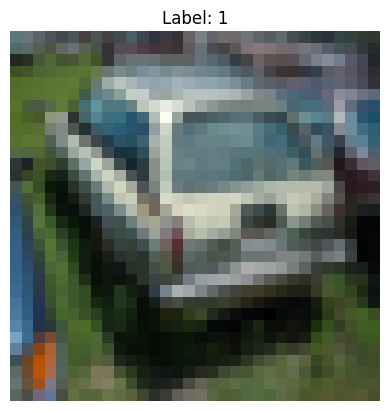

In [6]:
img = x[0].permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {y[0]}')
plt.show()

### MedMNIST

We first implement a global dataset class that will allow us to load any dataset in the medmnist library.

In [7]:
class MedMNISTDataset(Dataset):
    """
    PyTorch Dataset wrapper for MedMNIST datasets using dynamic instantiation.
    """

    def __init__(
        self,
        data_dir: str,
        dataset_name: str = 'BreastMNIST',
        image_size: int = 128,
        split: str = 'train',
        transform=None
    ):
        self.transform = transform or Compose([
            ToTensor(),
            Normalize((0,), (1,))
        ])

        self.dataset = instanciate_module(
            module_name='medmnist',
            class_name=dataset_name,
            params={
                "root": data_dir,
                "download": True,
                "transform": self.transform,
                "size": image_size,
                "split": split,
            }
        )

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int):
        x, y = self.dataset[idx]
        return x, y.squeeze(0)

We then create a dataloader object to load these datasets. Note that a random weighted sampler is used for the training split of each dataset to avoid imbalance and biases during training.

In [8]:
class MedMNISTDataloader(object):
    def __init__(self,
                 data_dir: str,
                 dataset_name: str = 'BreastMNIST',
                 batch_size: int = 4,
                 num_workers: int = 4,
                 image_size: int = 128,
                 debug: bool = True):

        super(MedMNISTDataloader, self).__init__()
        self.data_dir = data_dir
        self.dataset_name = dataset_name
        self.debug = debug
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.image_size = image_size

    def _create_random_sampler(self, dataset):
        labels = np.array([label for _, label in dataset])
        if labels.ndim > 1:
            labels = labels.flatten()
        labels = torch.tensor(labels, dtype=torch.int64)
        class_counts = torch.bincount(labels)
        class_weights = 1.0 / class_counts.float()
        sampler_weights = [class_weights[label] for _, label in dataset]
        sampler = WeightedRandomSampler(
            weights=sampler_weights, num_samples=len(dataset), replacement=True)
        return sampler

    
    def train(self):
        train_dataset = MedMNISTDataset(
            self.data_dir,
            self.dataset_name,
            self.image_size,
            split="train"
        )

        if self.debug:
            train_dataset = Subset(
                train_dataset, range(self.batch_size * 1000))

        random_sampler = self._create_random_sampler(train_dataset)

        return DataLoader(train_dataset, sampler=random_sampler, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True if torch.cuda.is_available() else False)

    def val(self):
        val_dataset = MedMNISTDataset(
            self.data_dir,
            self.dataset_name,
            self.image_size,
            split="val"
        )
        if self.debug:
            val_dataset = Subset(val_dataset, range(self.batch_size * 2))

        return DataLoader(val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True if torch.cuda.is_available() else False)

    def test(self):
        test_dataset = MedMNISTDataset(
            self.data_dir,
            self.dataset_name,
            self.image_size,
            split="test"
        )
        if self.debug:
            test_dataset = Subset(test_dataset, range(self.batch_size * 2))

        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True if torch.cuda.is_available() else False)

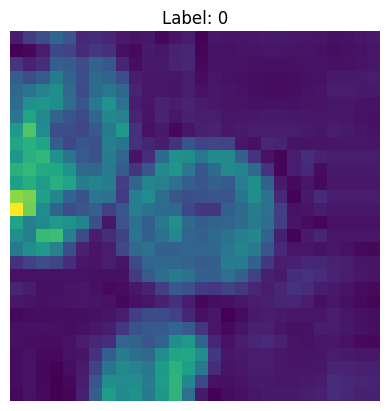

In [9]:
x, y = next(iter(MedMNISTDataloader(data_dir='../data', dataset_name='TissueMNIST', image_size=28).train()))
img = x[0].permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {y[0]}')
plt.show()

## Training the CNN

Here, we define a standard training and evaluation loop. The loop includes both the forward and backward passes, loss computation, weight updates via backpropagation, and performance tracking in terms of accuracy and loss.

### CIFAR10

For the CIFAR10 example, we use the Adam optimizer and a CrossEntropyLoss function.

In [17]:
n_epochs = 10
batch_size = 32
n_workers = 4
net = CNN(in_channels=3, out_channels=10, img_size=32)
net.to(device);
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def train(model, train_loader):
    model.train()
    train_loss = 0.0
    all_preds = []
    all_targets = []
    with tqdm(train_loader, leave=False, desc="Running training phase") as pbar:
        for sample in train_loader:
            data, targets = sample
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            all_preds.append(outputs)
            all_targets.append(targets)
            pbar.update(1)
    all_targets = torch.cat(all_targets)
    all_preds = torch.cat(all_preds)
    train_loss /= len(train_loader)
    return train_loss, all_preds, all_targets

def test(model, val_loader):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        with tqdm(val_loader, leave=False, desc="Running testing phase") as pbar:
            for _, sample in enumerate(val_loader):
                data, targets = sample
                data, targets = data.to(
                    device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                all_preds.append(outputs)
                all_targets.append(targets)
                pbar.update(1)

    all_targets = torch.cat(all_targets)
    all_preds = torch.cat(all_preds)
    test_loss /= len(val_loader)
    return test_loss, all_preds, all_targets

In [18]:
train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(n_epochs):
    train_loss, train_preds, train_targets = train(net, CIFAR10DataLoader(data_dir='../data', batch_size=batch_size, num_workers=n_workers).train())
    test_loss, test_preds, test_targets = test(net, CIFAR10DataLoader(data_dir='../data', batch_size=batch_size, num_workers=n_workers).val())
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = (train_preds.argmax(dim=1) ==
                        train_targets).float().mean().item()
    test_acc = (test_preds.argmax(dim=1) ==
                        test_targets).float().mean().item()
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"Epoch {epoch + 1} / {n_epochs} - Train/Test Loss : {train_loss:.4f} | {test_loss:.4f} - Train/Test Acc : {train_acc:.2f} | {test_acc:.2f}")

Epoch 1 / 10 - Train/Test Loss : 1.4987 | 1.2868 - Train/Test Acc : 0.46 | 0.54


Epoch 2 / 10 - Train/Test Loss : 1.1944 | 1.1789 - Train/Test Acc : 0.58 | 0.58


Epoch 3 / 10 - Train/Test Loss : 1.0408 | 1.1456 - Train/Test Acc : 0.63 | 0.60


Epoch 4 / 10 - Train/Test Loss : 0.9249 | 1.1455 - Train/Test Acc : 0.68 | 0.60


Epoch 5 / 10 - Train/Test Loss : 0.8226 | 1.1933 - Train/Test Acc : 0.71 | 0.60


Epoch 6 / 10 - Train/Test Loss : 0.7302 | 1.1707 - Train/Test Acc : 0.74 | 0.62


Epoch 7 / 10 - Train/Test Loss : 0.6471 | 1.2483 - Train/Test Acc : 0.77 | 0.61


Epoch 8 / 10 - Train/Test Loss : 0.5766 | 1.3212 - Train/Test Acc : 0.80 | 0.60


Epoch 9 / 10 - Train/Test Loss : 0.5094 | 1.4188 - Train/Test Acc : 0.82 | 0.60


Epoch 10 / 10 - Train/Test Loss : 0.4474 | 1.5080 - Train/Test Acc : 0.84 | 0.60


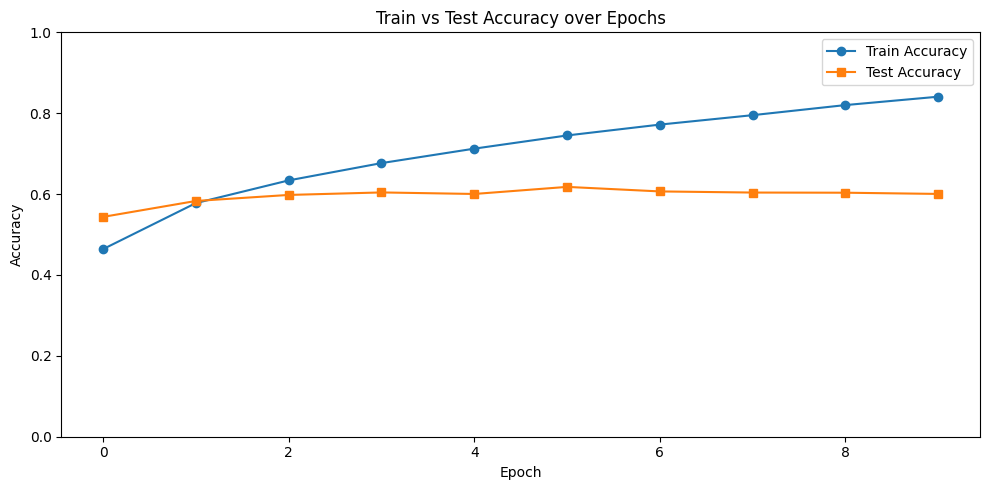

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(test_accs, label='Test Accuracy', marker='s')

plt.title('Train vs Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()